In [2]:
import numpy as np
import matplotlib.pyplot as plt

import struct
from tqdm import tqdm
import math as m
import h5py

In [3]:
import pandas as pd
import sys, os

sys.path.append("C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/MULE")

from packs.core import io as io

In [4]:
x = io.load_evt_info("C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/reproducibility_processed/RUN1_Air_1200V_FsC_dig1-DT5740-915_CH2_20250304134507-10.h5")

In [5]:
display(x)

,event_number,timestamp,samples,sampling_period,channels
0,2,850374929,501,16,1
1,3,850382195,501,16,1
2,4,1130583075,501,16,1
3,5,1300243023,501,16,1
4,6,1443685059,501,16,1
...,...,...,...,...,...
20824,24697,74200191681,501,16,1
20825,24698,74200193807,501,16,1
20826,24699,74203580173,501,16,1
20827,24701,74206854763,501,16,1


In [6]:
y = io.load_rwf_info("C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/reproducibility_processed/RUN1_Air_1200V_FsC_dig1-DT5740-915_CH2_20250304134507-10.h5", samples = 501)
display(y)

,event_number,channels,rwf
0,2,0,"[-34.188034, -34.188034, -34.188034, -34.18803..."
1,3,0,"[-34.188034, -33.699635, -33.211235, -33.21123..."
2,4,0,"[-33.699635, -33.699635, -33.211235, -33.69963..."
3,5,0,"[-32.72283, -33.211235, -33.211235, -33.211235..."
4,6,0,"[-33.699635, -33.699635, -33.699635, -33.21123..."
...,...,...,...
20824,24697,0,"[-33.211235, -32.72283, -33.211235, -33.211235..."
20825,24698,0,"[-33.699635, -33.211235, -34.188034, -33.69963..."
20826,24699,0,"[-32.234432, -31.74603, -31.74603, -32.234432,..."
20827,24701,0,"[-32.234432, -32.234432, -32.234432, -32.23443..."


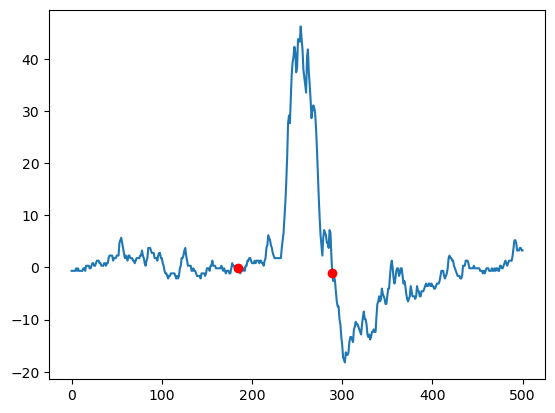

In [7]:
baseline_subtracted = y.copy(deep=True)

for i in range(len(baseline_subtracted.rwf)):
    baseline = np.mean(baseline_subtracted.rwf[i][150:200])
    baseline_subtracted.at[i, 'rwf'] = baseline_subtracted.rwf[i] - baseline

peak = np.argmax(baseline_subtracted.rwf[350])
for i in range(len(baseline_subtracted.rwf[350]) - peak):
    roi_end = peak + i
    if baseline_subtracted.rwf[350][roi_end] < 0:
        roi_end = peak + i
        break
roi_start = peak - 2*(roi_end - peak)

plt.plot(baseline_subtracted.rwf[350])
plt.plot(roi_start, baseline_subtracted.rwf[350][roi_start], 'ro')
plt.plot(roi_end, baseline_subtracted.rwf[350][roi_end], 'ro')
#plt.plot(baseline_subtracted.rwf[0])


In [8]:
rois = baseline_subtracted.copy(deep=True)

for i in range(len(rois.rwf)):
    peak = np.argmax(baseline_subtracted.rwf[i])
    for j in range(len(baseline_subtracted.rwf[i]) - peak):
        roi_end = peak + j
        if baseline_subtracted.rwf[i][roi_end] < 0:
            roi_end = peak + j
            break
    roi_start = peak - 2*(roi_end - peak)
    rois.at[i, 'rwf'] = baseline_subtracted.rwf[i][roi_start:roi_end]
    #plt.plot(baseline_subtracted.rwf[i])
    #plt.plot(roi_start, baseline_subtracted.rwf[i][roi_start], 'ro')
    #plt.plot(roi_end, baseline_subtracted.rwf[i][roi_end], 'ro')
    #plt.show()

In [9]:
interval = 8.016*10**-6 / len(baseline_subtracted.rwf[0])

areas = np.zeros(len(baseline_subtracted.rwf))
areas_rois = np.zeros(len(rois.rwf))
trapareas_rois = np.zeros(len(rois.rwf))

for i in range(len(rois.rwf)):
    for j in range(len(rois.rwf[i])-1):
        if (rois.rwf[i][j] + rois.rwf[i][j+1]) > 0:
            trapareas_rois[i] += (rois.rwf[i][j] + rois.rwf[i][j+1])/2  * interval

for i in range(len(rois.rwf)):
    for j in range(len(rois.rwf[i])):
        if rois.rwf[i][j] > 0:
            areas_rois[i] += rois.rwf[i][j] * interval

for i in range(len(baseline_subtracted.rwf)):
    for j in range(len(baseline_subtracted.rwf[i])):
        if baseline_subtracted.rwf[i][j] > 0:
            areas[i] += baseline_subtracted.rwf[i][j] * interval

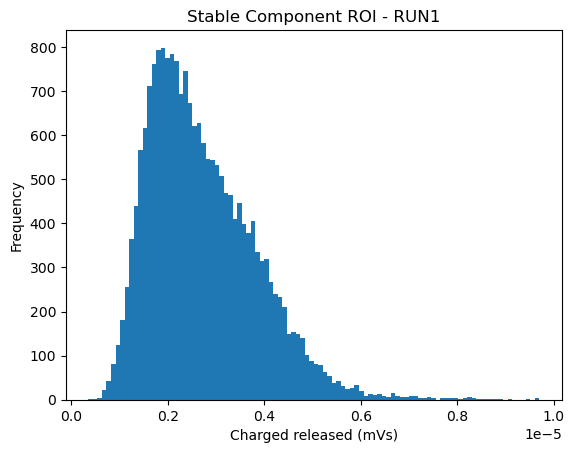

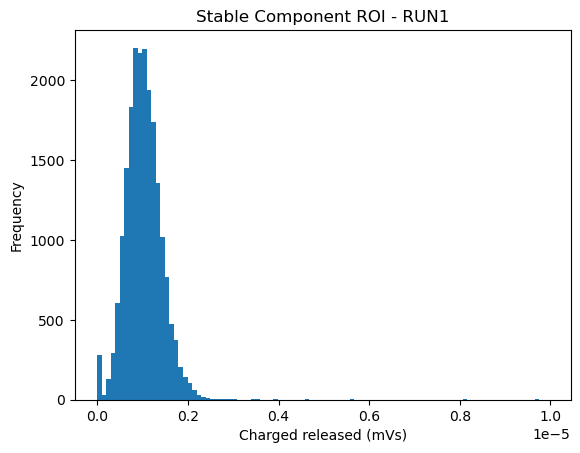

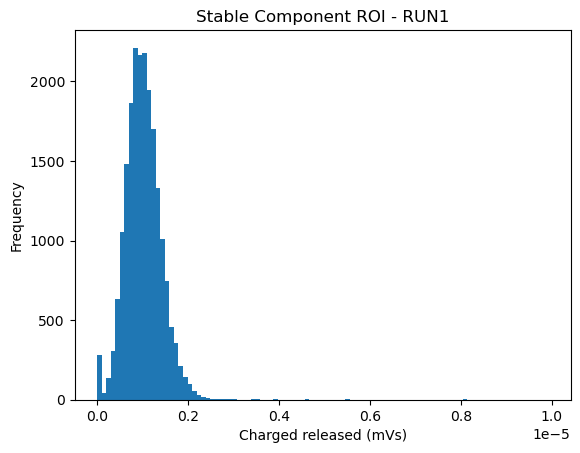

In [10]:
for i in [areas, areas_rois, trapareas_rois]:
    areas_filtered = i[i < 0.00001]
    #areas_filtered = areas_filtered[areas_filtered > 0.00001]
    #areas_filtered = areas_filtered[areas_filtered < 0.00001]
    hist = plt.hist(areas_filtered, bins=100)
    plt.xlabel("Charged released (mVs)")
    plt.ylabel("Frequency")
    plt.title("Stable Component ROI - RUN1")
    plt.show()

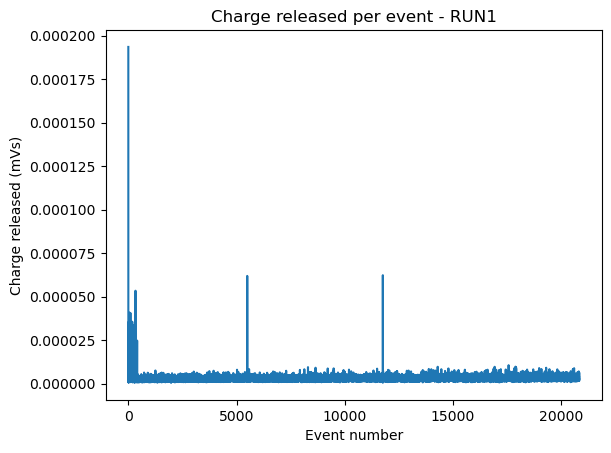

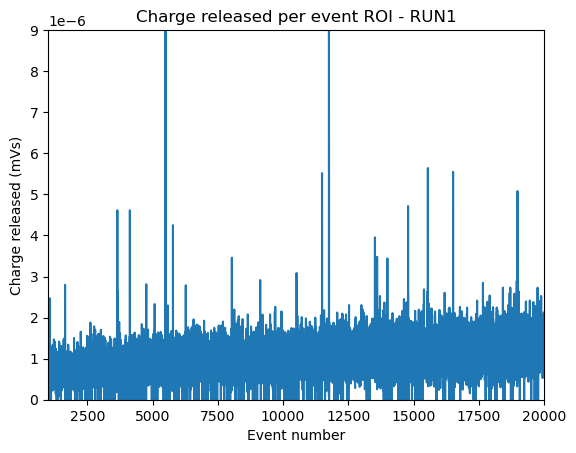

In [22]:
plt.plot(areas)
plt.xlabel("Event number")
plt.title("Charge released per event - RUN1")
plt.ylabel("Charge released (mVs)")
plt.show()
#plt.yscale('log')

#plt.ylim(0,0.00001)

plt.plot(trapareas_rois)
plt.xlabel("Event number")
plt.title("Charge released per event ROI - RUN1")
plt.ylabel("Charge released (mVs)")
plt.xlim(1000, 20000)
plt.ylim(0,0.000009)
#plt.yscale('log')
plt.show()

In [12]:
def reprod_avg(filename, run, disp=False):
    
    x = io.load_evt_info("C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/reproducibility_processed/" + filename)
    if disp == True: display(x)
    y = io.load_rwf_info("C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/reproducibility_processed/" + filename, samples = 501)
    if disp == True: display(y)

    baseline_subtracted = y.copy(deep=True)


    for i in range(len(baseline_subtracted.rwf)):
        baseline = np.mean(baseline_subtracted.rwf[i][150:200])
        baseline_subtracted.at[i, 'rwf'] = baseline_subtracted.rwf[i] - baseline

    rois = baseline_subtracted.copy(deep=True)

    for i in range(len(rois.rwf)):
        peak = np.argmax(baseline_subtracted.rwf[i])
        for j in range(len(baseline_subtracted.rwf[i]) - peak):
            roi_end = peak + j
            if baseline_subtracted.rwf[i][roi_end] < 0:
                roi_end = peak + j
                break
        roi_start = peak - 2*(roi_end - peak)
        rois.at[i, 'rwf'] = baseline_subtracted.rwf[i][roi_start:roi_end]

    
    interval = 8.016*10**-6 / len(baseline_subtracted.rwf[0])

    areas = np.zeros(len(rois.rwf))

    for i in range(len(rois.rwf)):
        for j in range(len(rois.rwf[i])-1):
            if (rois.rwf[i][j] + rois.rwf[i][j+1]) > 0:
                areas[i] += (rois.rwf[i][j] + rois.rwf[i][j+1])/2  * interval
    
    plt.plot(areas)
    plt.xlabel("Event number")
    plt.ylabel("Charge released (mVs)")
    plt.title("Charge released per event - RUN" + run)
    plt.show()

    stable_comp = areas[areas < 0.00001]
    hist = plt.hist(stable_comp, bins=100)
    plt.xlabel("Charged released (mVs)")
    plt.ylabel("Frequency")
    plt.title("Stable Component - RUN" + run)
    plt.show()

    large_comp = areas[areas < 0.00002]
    large_comp = large_comp[large_comp > 0.00001]
    hist = plt.hist(large_comp, bins=100)
    plt.xlabel("Charged released (mVs)")
    plt.ylabel("Frequency")
    plt.title("Initial Larger Component - RUN" + run)
    plt.show()

    stable_mean = np.mean(stable_comp)
    print(stable_mean)
    stable_stdev = np.std(stable_comp)
    print(stable_stdev)

    return areas, baseline_subtracted, stable_mean, stable_stdev


,event_number,timestamp,samples,sampling_period,channels
0,2,850374929,501,16,1
1,3,850382195,501,16,1
2,4,1130583075,501,16,1
3,5,1300243023,501,16,1
4,6,1443685059,501,16,1
...,...,...,...,...,...
20824,24697,74200191681,501,16,1
20825,24698,74200193807,501,16,1
20826,24699,74203580173,501,16,1
20827,24701,74206854763,501,16,1


,event_number,channels,rwf
0,2,0,"[-34.188034, -34.188034, -34.188034, -34.18803..."
1,3,0,"[-34.188034, -33.699635, -33.211235, -33.21123..."
2,4,0,"[-33.699635, -33.699635, -33.211235, -33.69963..."
3,5,0,"[-32.72283, -33.211235, -33.211235, -33.211235..."
4,6,0,"[-33.699635, -33.699635, -33.699635, -33.21123..."
...,...,...,...
20824,24697,0,"[-33.211235, -32.72283, -33.211235, -33.211235..."
20825,24698,0,"[-33.699635, -33.211235, -34.188034, -33.69963..."
20826,24699,0,"[-32.234432, -31.74603, -31.74603, -32.234432,..."
20827,24701,0,"[-32.234432, -32.234432, -32.234432, -32.23443..."


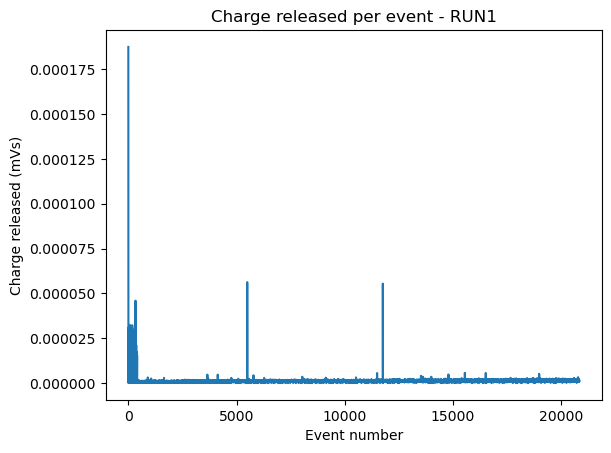

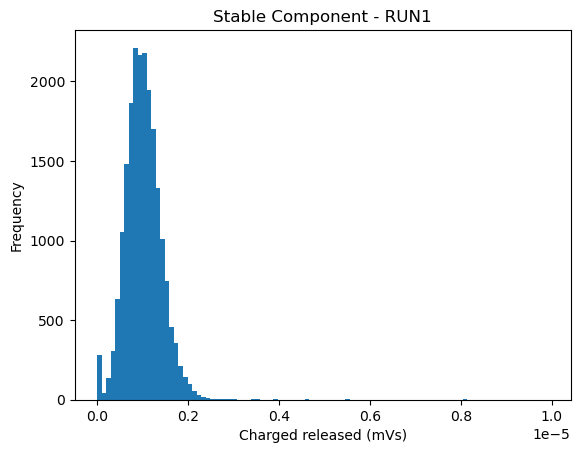

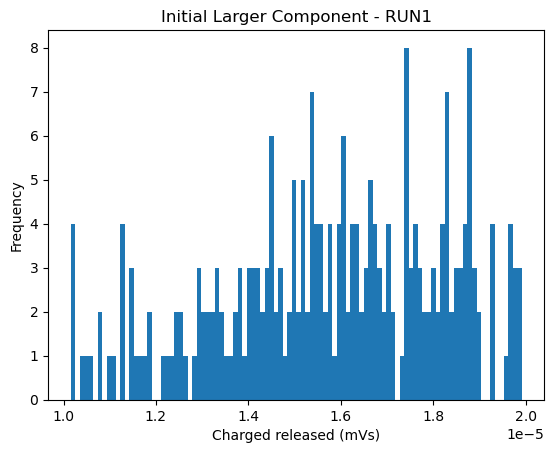

1.020080140823135e-06
4.298373649054305e-07


In [23]:
areas1, waveforms1, mean1, stdev1 = reprod_avg("RUN1_Air_1200V_FsC_dig1-DT5740-915_CH2_20250304134507-10.h5", "1", disp=True)

,event_number,timestamp,samples,sampling_period,channels
0,2,2173101,501,16,1
1,7,7037703,501,16,1
2,10,11983703,501,16,1
3,12,16944407,501,16,1
4,15,21876763,501,16,1
...,...,...,...,...,...
17456,30376,117359466623,501,16,1
17457,30377,117367021121,501,16,1
17458,30378,117370682907,501,16,1
17459,30380,117374368773,501,16,1


,event_number,channels,rwf
0,2,0,"[-34.188034, -34.188034, -33.211235, -32.72283..."
1,7,0,"[-33.211235, -32.72283, -33.699635, -34.188034..."
2,10,0,"[-34.676434, -35.164837, -35.164837, -34.18803..."
3,12,0,"[-35.164837, -35.653236, -35.164837, -35.16483..."
4,15,0,"[-33.699635, -33.699635, -33.699635, -33.21123..."
...,...,...,...
17456,30376,0,"[-35.653236, -35.653236, -35.653236, -35.16483..."
17457,30377,0,"[-23.443224, -24.420025, -25.396826, -27.35042..."
17458,30378,0,"[-34.188034, -34.188034, -33.699635, -34.18803..."
17459,30380,0,"[-34.676434, -34.676434, -34.676434, -34.67643..."


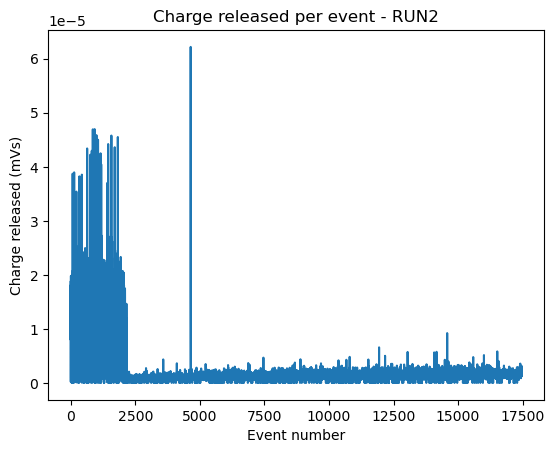

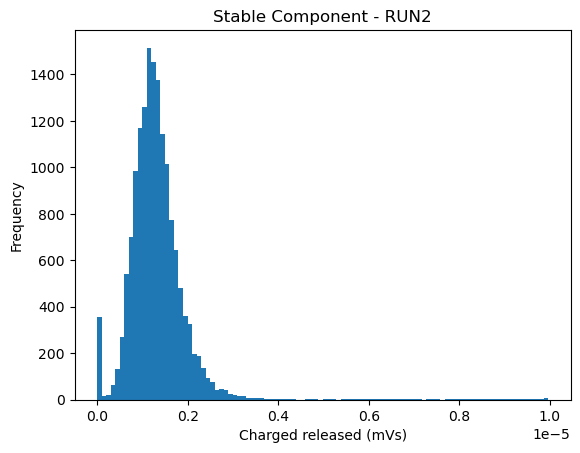

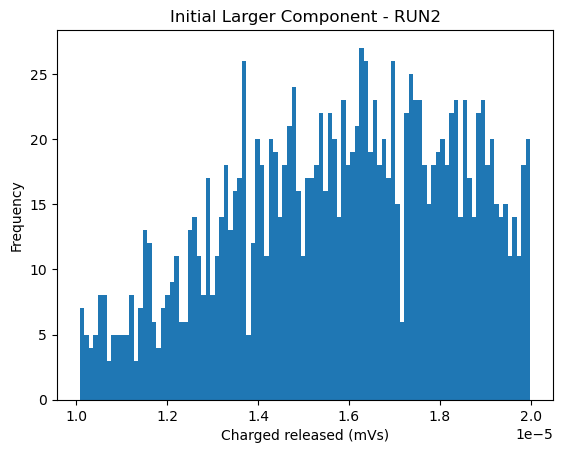

1.3347794517039947e-06
7.717386696867682e-07


In [ ]:
areas2, waveforms2, mean2, stdev2 = reprod_avg("RUN2_Air_1200V_FsC_dig1-DT5740-915_CH2_20250304140802-11.h5", "2", disp=True)

,event_number,timestamp,samples,sampling_period,channels
0,2,868486445,501,16,1
1,6,872539027,501,16,1
2,12,876776737,501,16,1
3,16,880972283,501,16,1
4,20,885247033,501,16,1
...,...,...,...,...,...
28200,33883,84741126199,501,16,1
28201,33884,84744372971,501,16,1
28202,33885,84747957965,501,16,1
28203,33886,84751348035,501,16,1


,event_number,channels,rwf
0,2,0,"[-33.699635, -33.699635, -33.699635, -33.69963..."
1,6,0,"[-33.211235, -33.211235, -31.74603, -32.234432..."
2,12,0,"[-33.211235, -33.699635, -34.188034, -34.18803..."
3,16,0,"[-32.72283, -33.211235, -33.211235, -32.72283,..."
4,20,0,"[-32.234432, -32.234432, -32.72283, -33.211235..."
...,...,...,...
28200,33883,0,"[-34.188034, -33.699635, -34.188034, -34.18803..."
28201,33884,0,"[-33.699635, -33.699635, -34.188034, -33.69963..."
28202,33885,0,"[-33.699635, -33.211235, -33.699635, -33.69963..."
28203,33886,0,"[-32.72283, -32.72283, -32.72283, -32.234432, ..."


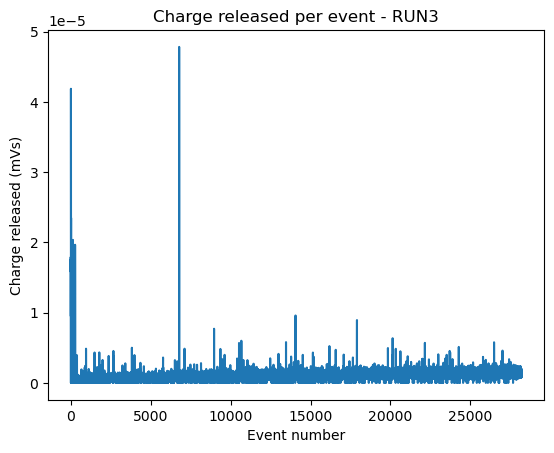

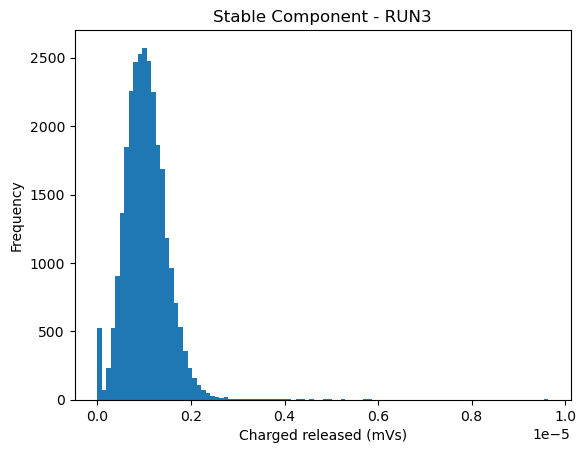

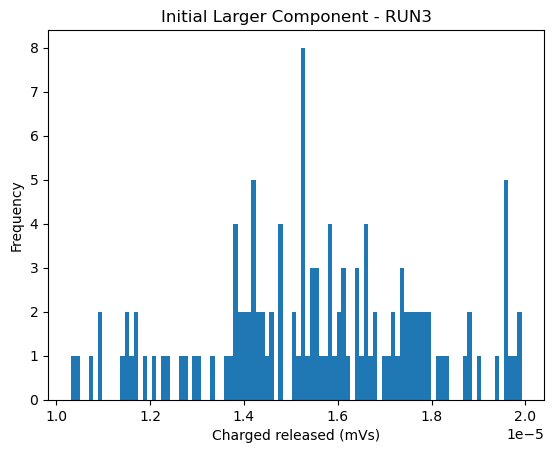

1.0435309321528628e-06
4.7648796370679894e-07


In [ ]:
areas3, waveforms3, mean3, stdev3 = reprod_avg("RUN3_Air_1200V_FsC_dig1-DT5740-915_CH2_20250304143956-12.h5", "3", disp=True)

,event_number,timestamp,samples,sampling_period,channels
0,2,1692038593,501,16,1
1,3,1692044839,501,16,1
2,5,1704366777,501,16,1
3,8,1704368019,501,16,1
4,9,1711090561,501,16,1
...,...,...,...,...,...
30287,37257,63856522249,501,16,1
30288,37258,63860126169,501,16,1
30289,37259,63860128573,501,16,1
30290,37260,63863589791,501,16,1


,event_number,channels,rwf
0,2,0,"[-35.164837, -35.164837, -35.164837, -35.65323..."
1,3,0,"[-33.699635, -34.188034, -34.676434, -34.18803..."
2,5,0,"[-34.676434, -34.676434, -34.676434, -33.69963..."
3,8,0,"[-31.74603, -31.257631, -31.257631, -31.74603,..."
4,9,0,"[-34.676434, -34.676434, -34.188034, -34.18803..."
...,...,...,...
30287,37257,0,"[-34.188034, -34.676434, -34.676434, -34.18803..."
30288,37258,0,"[-34.676434, -34.676434, -35.164837, -35.16483..."
30289,37259,0,"[-35.164837, -34.676434, -35.164837, -35.16483..."
30290,37260,0,"[-36.141636, -36.630035, -35.164837, -34.67643..."


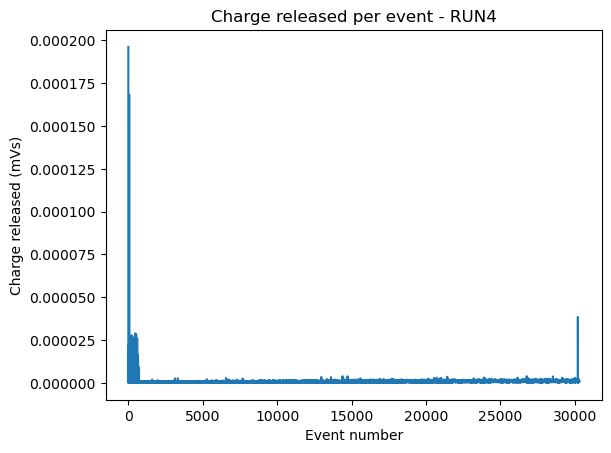

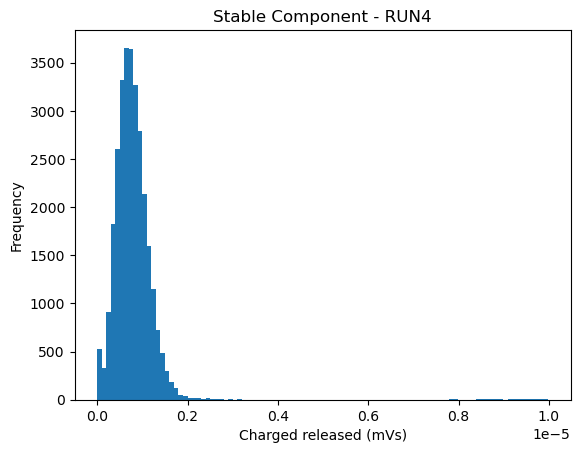

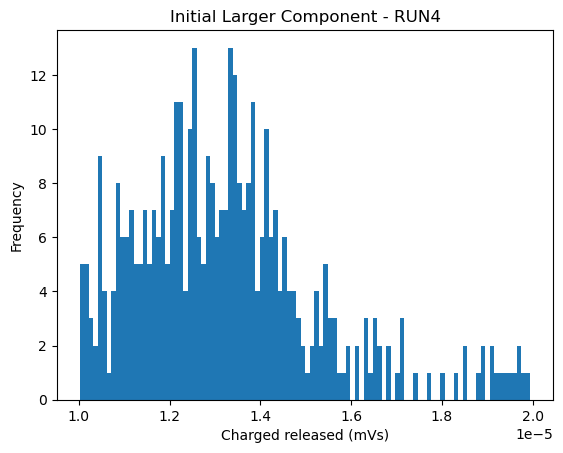

8.009284582806444e-07
5.807952945555477e-07


In [ ]:
areas4, waveforms4, mean4, stdev4 = reprod_avg("RUN4_Air_1200V_FsC_dig1-DT5740-915_CH2_20250304150622-13.h5", "4", disp=True)

,event_number,timestamp,samples,sampling_period,channels
0,2,302272673,501,16,1
1,4,310483787,501,16,1
2,5,316997485,501,16,1
3,8,323006929,501,16,1
4,11,328883641,501,16,1
...,...,...,...,...,...
4322,16524,62806639913,501,16,1
4323,16525,62811017673,501,16,1
4324,16526,64330328169,501,16,1
4325,16527,64343911081,501,16,1


,event_number,channels,rwf
0,2,0,"[-33.699635, -33.699635, -33.699635, -33.69963..."
1,4,0,"[-33.211235, -33.211235, -33.211235, -33.21123..."
2,5,0,"[-34.188034, -34.188034, -34.188034, -33.69963..."
3,8,0,"[-34.188034, -34.676434, -34.676434, -34.18803..."
4,11,0,"[-32.72283, -32.72283, -32.72283, -33.211235, ..."
...,...,...,...
4322,16524,0,"[-34.188034, -34.188034, -34.188034, -34.18803..."
4323,16525,0,"[-33.211235, -33.211235, -33.211235, -33.21123..."
4324,16526,0,"[-33.699635, -33.699635, -34.188034, -33.69963..."
4325,16527,0,"[-34.188034, -34.188034, -34.188034, -34.18803..."


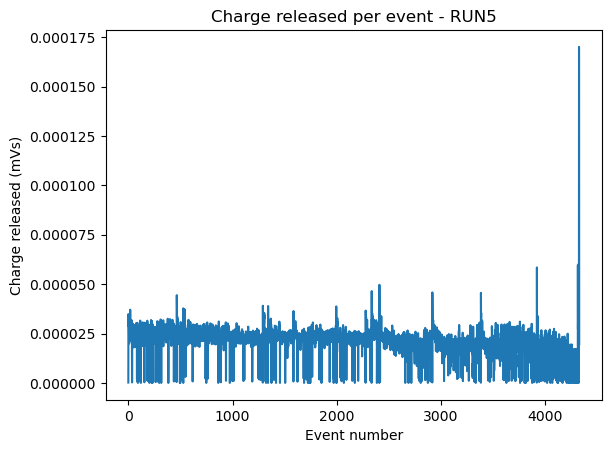

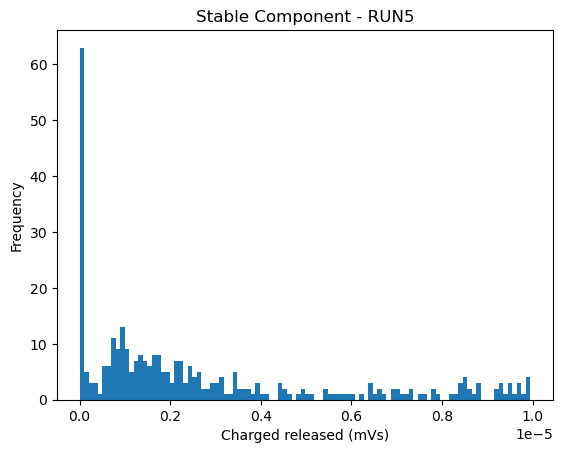

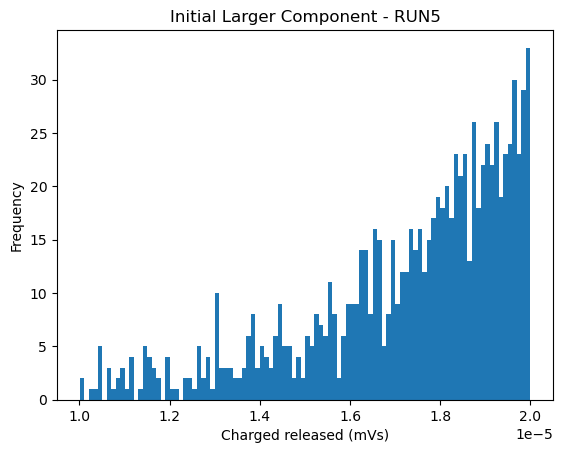

2.663720735729646e-06
2.8728771591384127e-06


In [ ]:
areas5, waveforms5, mean5, stdev5 = reprod_avg("RUN5_Air_1200V_FsC_dig1-DT5740-915_CH2_20250304153412-14.h5", "5", disp=True)

,event_number,timestamp,samples,sampling_period,channels
0,2,358983,501,16,1
1,6,5318437,501,16,1
2,8,12327753,501,16,1
3,13,18942143,501,16,1
4,19,25087939,501,16,1
...,...,...,...,...,...
12099,21918,100214811333,501,16,1
12100,21919,100226149841,501,16,1
12101,21920,100237629995,501,16,1
12102,21921,100312372355,501,16,1


,event_number,channels,rwf
0,2,0,"[-32.72283, -33.211235, -33.699635, -34.188034..."
1,6,0,"[-34.676434, -34.676434, -34.676434, -35.16483..."
2,8,0,"[-34.676434, -35.164837, -35.164837, -34.67643..."
3,13,0,"[-34.188034, -33.211235, -33.211235, -33.21123..."
4,19,0,"[-35.653236, -35.653236, -35.653236, -35.65323..."
...,...,...,...
12099,21918,0,"[-34.188034, -33.699635, -34.676434, -34.18803..."
12100,21919,0,"[-34.188034, -33.699635, -33.211235, -33.69963..."
12101,21920,0,"[-33.699635, -34.188034, -33.699635, -34.18803..."
12102,21921,0,"[-32.234432, -31.74603, -30.28083, -31.257631,..."


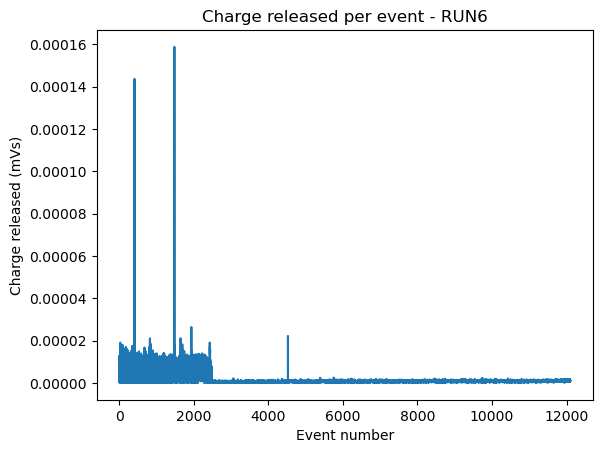

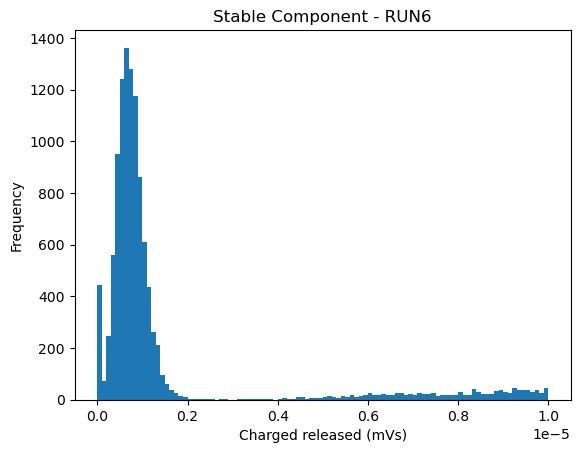

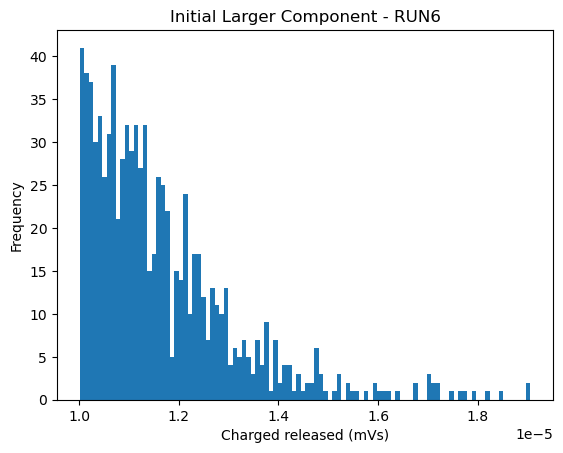

1.5017057602923404e-06
2.285733278515469e-06


In [ ]:
areas6, waveforms6, mean6, stdev6 = reprod_avg("RUN6_Air_1200V_FsC_dig1-DT5740-915_CH2_20250304160638-15.h5", "6", disp=True)

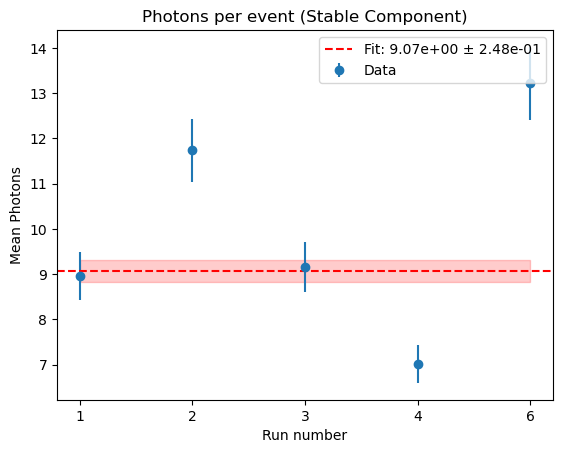

In [ ]:
means = np.array([mean1, mean2, mean3, mean4, mean6])
photons = (means / 1e3 - 8.42e-12) / 1.13e-10
stdevs = np.array([
    stdev1 / np.sqrt(len(areas1)), 
    stdev2 / np.sqrt(len(areas2)), 
    stdev3 / np.sqrt(len(areas3)), 
    stdev4 / np.sqrt(len(areas4)), 
    stdev6 / np.sqrt(len(areas6))
])
photon_err = np.sqrt((stdevs / means) ** 2 + (6.71e-12 / 1.13e-10) ** 2) * photons + 1.11e-11

x_vals = np.arange(len(means))
x_labels = [1, 2, 3, 4, 6]

# Compute the weighted mean and its error
weights = 1 / photon_err**2
constant_fit = np.sum(photons * weights) / np.sum(weights)
constant_fit_err = np.sqrt(1 / np.sum(weights))

plt.errorbar(x_vals, photons, yerr=photon_err, fmt='o', label="Data")

# Plot horizontal best-fit line
plt.axhline(y=constant_fit, color='r', linestyle='--', label=f'Fit: {constant_fit:.2e} ± {constant_fit_err:.2e}')

# Add shaded error region for the fit
plt.fill_between(x_vals, constant_fit - constant_fit_err, constant_fit + constant_fit_err, color='r', alpha=0.2)

# Customize x-axis labels
plt.xticks(x_vals, x_labels)

plt.xlabel("Run number")
plt.ylabel("Mean Photons")
plt.title("Photons per event (Stable Component)")
plt.legend()

plt.show()

Text(0.5, 1.0, 'Stable Components')

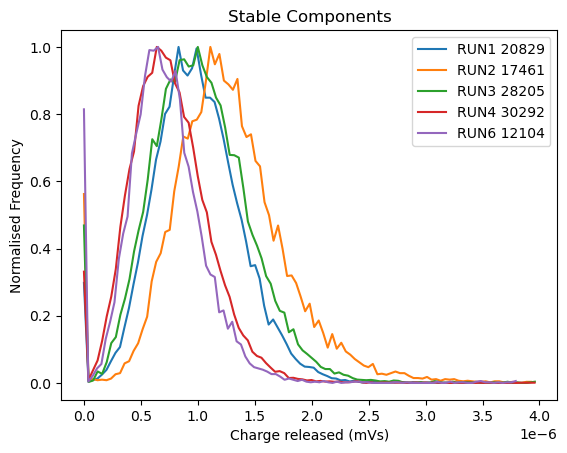

In [ ]:
stable_comp1 = areas1[areas1 < 0.000004]
hist1 = np.histogram(stable_comp1, bins=100)
stable_comp2 = areas2[areas2 < 0.000004]
hist2 = np.histogram(stable_comp2, bins=100)
stable_comp3 = areas3[areas3 < 0.000004]
hist3 = np.histogram(stable_comp3, bins=100)
stable_comp4 = areas4[areas4 < 0.000004]
hist4 = np.histogram(stable_comp4, bins=100)
stable_comp6 = areas6[areas6 < 0.000004]
hist6 = np.histogram(stable_comp6, bins=100)

plt.plot(hist1[1][0:-1], hist1[0]/np.max(hist1[0]), label=("RUN1 " + str(len(areas1))))
plt.plot(hist2[1][0:-1], hist2[0]/np.max(hist2[0]), label="RUN2 " + str(len(areas2)))
plt.plot(hist3[1][0:-1], hist3[0]/np.max(hist3[0]), label="RUN3 " + str(len(areas3)))
plt.plot(hist4[1][0:-1], hist4[0]/np.max(hist4[0]), label="RUN4 " + str(len(areas4)))
plt.plot(hist6[1][0:-1], hist6[0]/np.max(hist6[0]), label="RUN6 " + str(len(areas6)))
plt.legend()
plt.ylabel("Normalised Frequency")
plt.xlabel("Charge released (mVs)")
plt.title("Stable Components")


In [ ]:
from scipy.optimize import curve_fit

# Define an improved Landau function approximation
def landau_pdf(x, mpv, eta, A):
    """
    Landau distribution approximation for fitting.
    """
    lambda_ = (x - mpv) / eta
    landau_shape = np.exp(-lambda_ - np.exp(-lambda_))  # Empirical approximation
    return A * landau_shape

def landau_fit(data, run):

    # Create histogram
    hist_values, bin_edges = np.histogram(data, bins=100)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Midpoints of bins

    # Improved initial guess
    mpv_guess = bin_centers[np.argmax(hist_values)]  # Peak of histogram
    eta_guess = np.std(data) / 3  # Approximate width
    A_guess = max(hist_values)  # Amplitude

    initial_guess = [mpv_guess, eta_guess, A_guess]

    # Perform curve fitting
    try:
        popt, pcov = curve_fit(landau_pdf, bin_centers, hist_values, p0=initial_guess, maxfev=50000)
    
        # Extract fit parameters with errors
        mpv_fit, eta_fit, A_fit = popt
        mpv_err, eta_err, A_err = np.sqrt(np.diag(pcov))

        # Generate fitted curve
        x_fit = np.linspace(min(data), max(data), 500)
        y_fit = landau_pdf(x_fit, *popt)

        # Plot histogram and fit
        plt.hist(data, bins=100, alpha=0.5, label="Data Histogram")
        plt.plot(x_fit, y_fit, 'r-', label=f'Landau Fit: MPV={mpv_fit:.2e} ± {mpv_err:.2e}, Width={eta_fit:.2e} ± {eta_err:.2e}')
        plt.xlabel("Charge released (mVs)")
        plt.ylabel("Density")
        plt.title("Landau Fit to Data - RUN" + run)
        plt.legend()
        plt.show()

    except RuntimeError as e:
        print(f"Fit failed: {e}")
    
    return mpv_fit, eta_fit, mpv_err, eta_err

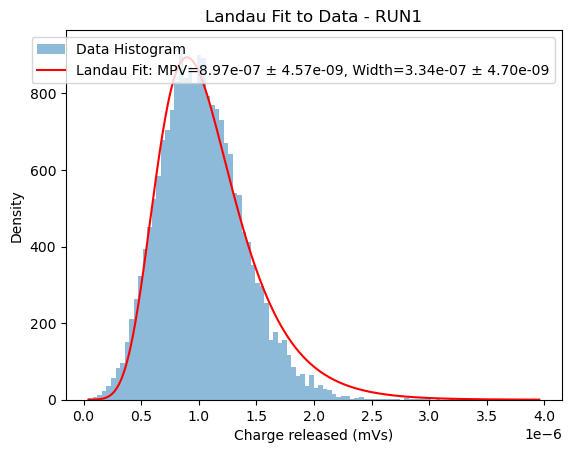

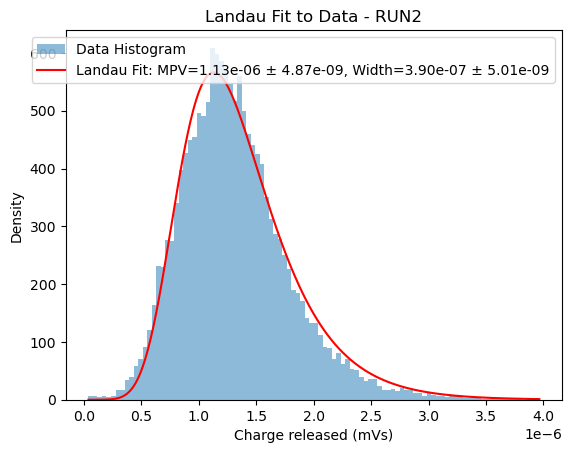

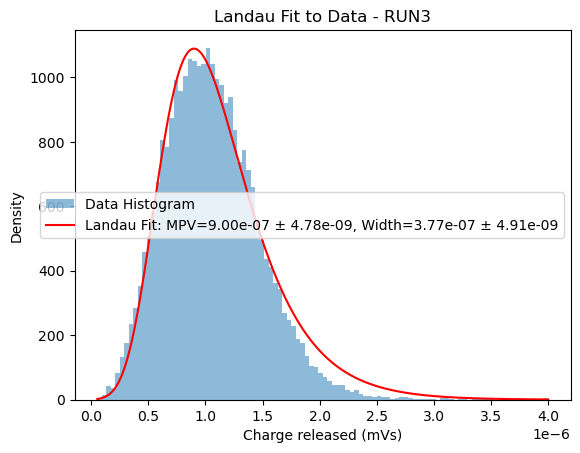

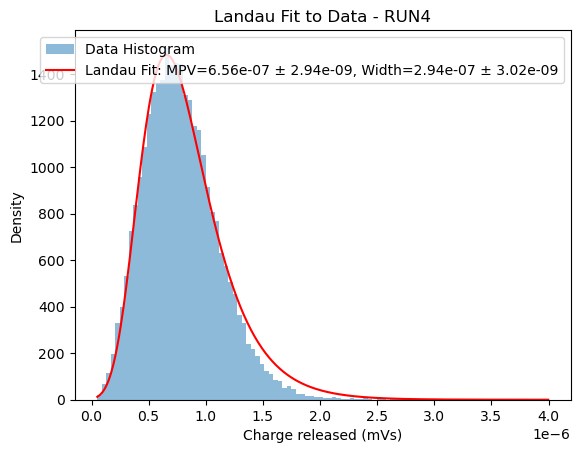

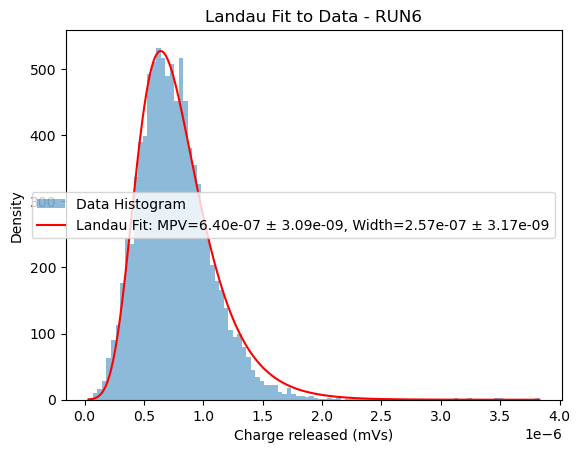

In [ ]:
areas1_filt = areas1[areas1 < 0.000004]
areas2_filt = areas2[areas2 < 0.000004]
areas3_filt = areas3[areas3 < 0.000004]
areas4_filt = areas4[areas4 < 0.000004]
areas6_filt = areas6[areas6 < 0.000004]

mpv_fit1, eta_fit1, mpv_err1, eta_err1 = landau_fit(areas1_filt[areas1_filt != 0], "1")
mpv_fit2, eta_fit2, mpv_err2, eta_err2 = landau_fit(areas2_filt[areas2_filt != 0], "2")
mpv_fit3, eta_fit3, mpv_err3, eta_err3 = landau_fit(areas3_filt[areas3_filt != 0], "3")
mpv_fit4, eta_fit4, mpv_err4, eta_err4 = landau_fit(areas4_filt[areas4_filt != 0], "4")
mpv_fit6, eta_fit6, mpv_err6, eta_err6 = landau_fit(areas6_filt[areas6_filt != 0], "6")

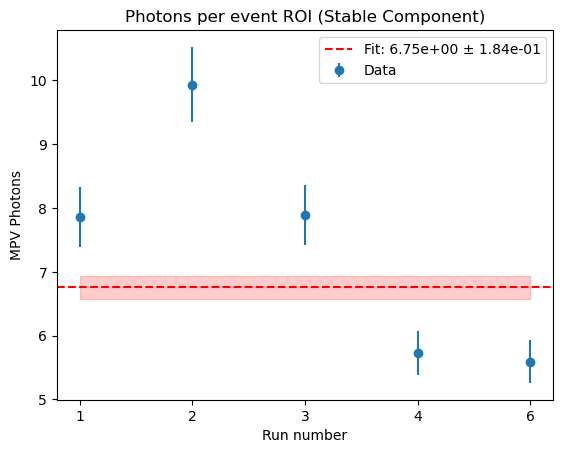

In [ ]:
means = np.array([mpv_fit1, mpv_fit2, mpv_fit3, mpv_fit4, mpv_fit6])
photons = (means / 1e3 - 8.42e-12) / 1.13e-10
stdevs = np.array([mpv_err1, mpv_err2, mpv_err3, mpv_err4, mpv_err6])
photon_err = np.sqrt((stdevs / means) ** 2 + (6.71e-12 / 1.13e-10) ** 2) * photons + 1.11e-11

x_vals = np.arange(len(means))
x_labels = [1, 2, 3, 4, 6]

# Compute the weighted mean and its error
weights = 1 / photon_err**2
constant_fit = np.sum(photons * weights) / np.sum(weights)
constant_fit_err = np.sqrt(1 / np.sum(weights))

plt.errorbar(x_vals, photons, yerr=photon_err, fmt='o', label="Data")

# Plot horizontal best-fit line
plt.axhline(y=constant_fit, color='r', linestyle='--', label=f'Fit: {constant_fit:.2e} ± {constant_fit_err:.2e}')

# Add shaded error region for the fit
plt.fill_between(x_vals, constant_fit - constant_fit_err, constant_fit + constant_fit_err, color='r', alpha=0.2)

# Customize x-axis labels
plt.xticks(x_vals, x_labels)

plt.xlabel("Run number")
plt.ylabel("MPV Photons")
plt.title("Photons per event ROI (Stable Component)")
plt.legend()

plt.show()

Smaller stable component window:

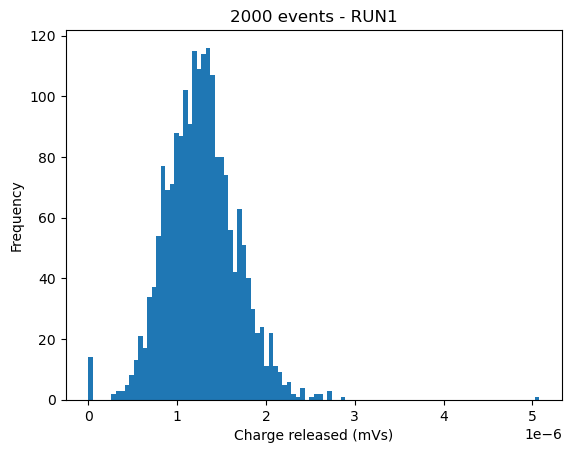

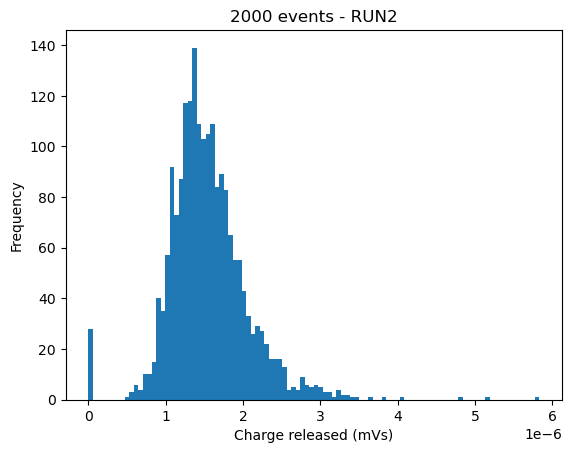

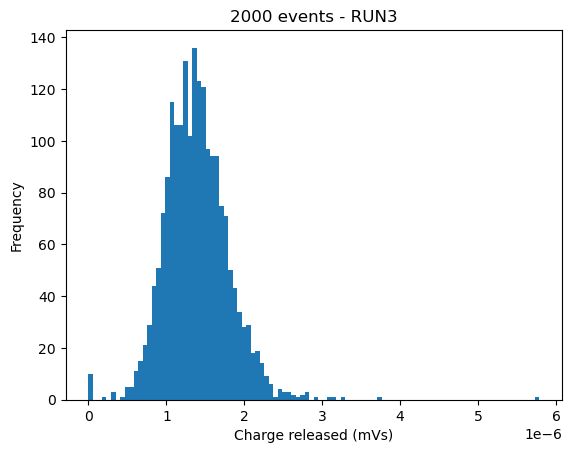

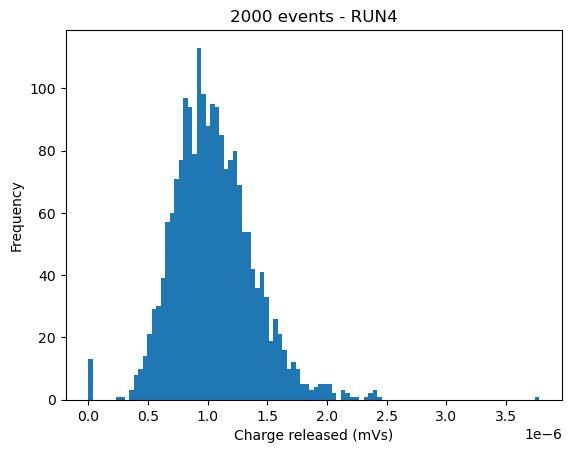

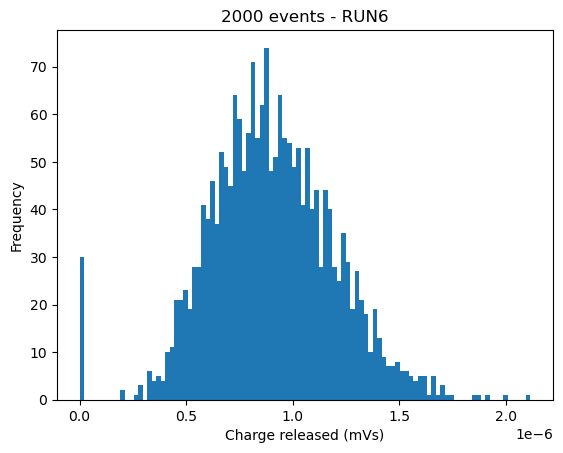

In [ ]:
#areas1_small = areas1[1000:3000]
areas1_small = areas1[18000:20000]
plt.title("2000 events - RUN1")
plt.xlabel("Charge released (mVs)")
plt.ylabel("Frequency")
smallhist1 = plt.hist(areas1_small, bins=100)
plt.show()

#areas2_small = areas2[2000:4000][areas2[2000:4000] < 0.00001]
areas2_small = areas2[15000:17000]
plt.title("2000 events - RUN2")
plt.xlabel("Charge released (mVs)")
plt.ylabel("Frequency")
smallhist2 = plt.hist(areas2_small, bins=100)
plt.show()

#areas3_small = areas3[1000:3000]
areas3_small = areas3[25000:27000]
plt.title("2000 events - RUN3")
plt.xlabel("Charge released (mVs)")
plt.ylabel("Frequency")
smallhist3 = plt.hist(areas3_small, bins=100)
plt.show()

#areas4_small = areas4[1000:3000]
areas4_small = areas4[27000:29000]
plt.title("2000 events - RUN4")
plt.xlabel("Charge released (mVs)")
plt.ylabel("Frequency")
smallhist4 = plt.hist(areas4_small, bins=100)
plt.show()

#areas6_small = areas6[3000:5000][areas6[3000:5000] < 0.00001]
areas6_small = areas6[10000:12000]
plt.title("2000 events - RUN6")
plt.xlabel("Charge released (mVs)")
plt.ylabel("Frequency")
smallhist6 = plt.hist(areas6_small, bins=100)
plt.show()

Text(0.5, 1.0, '~2000 Events')

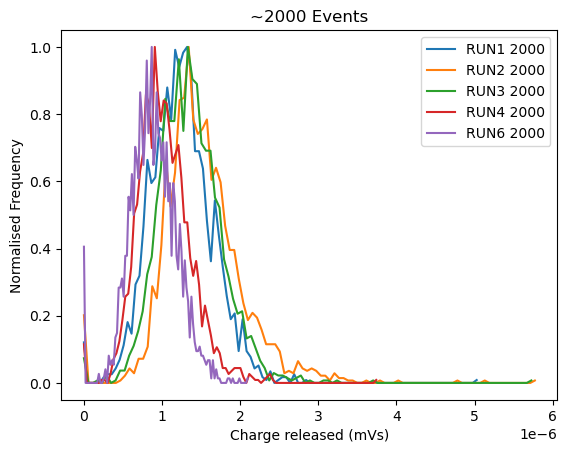

In [ ]:
small_hist1 = np.histogram(areas1_small, bins=100)
small_hist2 = np.histogram(areas2_small, bins=100)
small_hist3 = np.histogram(areas3_small, bins=100)
small_hist4 = np.histogram(areas4_small, bins=100)
small_hist6 = np.histogram(areas6_small, bins=100)

plt.plot(small_hist1[1][0:-1], small_hist1[0]/np.max(small_hist1[0]), label="RUN1 " + str(len(areas1_small)))
plt.plot(small_hist2[1][0:-1], small_hist2[0]/np.max(small_hist2[0]), label="RUN2 " + str(len(areas2_small)))
plt.plot(small_hist3[1][0:-1], small_hist3[0]/np.max(small_hist3[0]), label="RUN3 " + str(len(areas3_small)))
plt.plot(small_hist4[1][0:-1], small_hist4[0]/np.max(small_hist4[0]), label="RUN4 " + str(len(areas4_small)))
plt.plot(small_hist6[1][0:-1], small_hist6[0]/np.max(small_hist6[0]), label="RUN6 " + str(len(areas6_small)))
plt.legend()
plt.ylabel("Normalised Frequency")
plt.xlabel("Charge released (mVs)")
plt.title("~2000 Events")

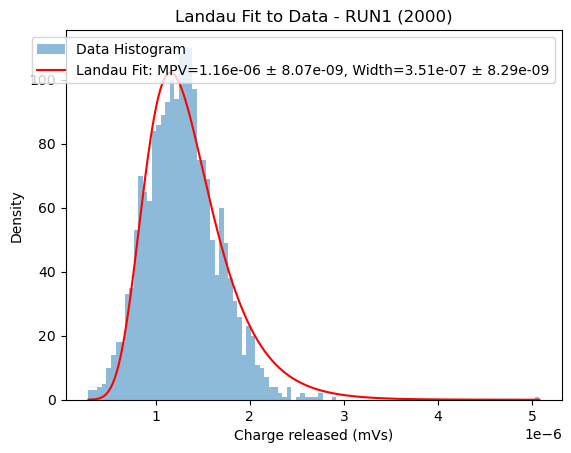

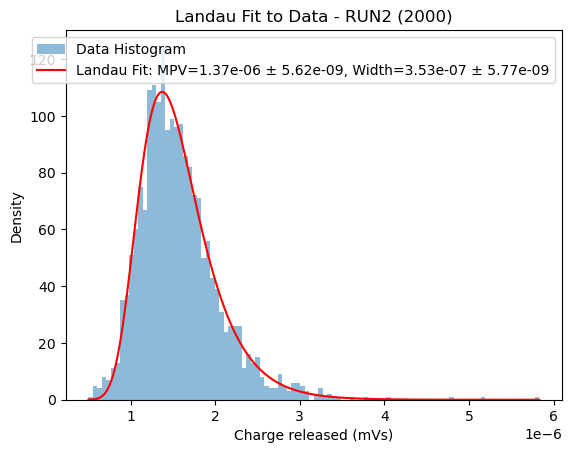

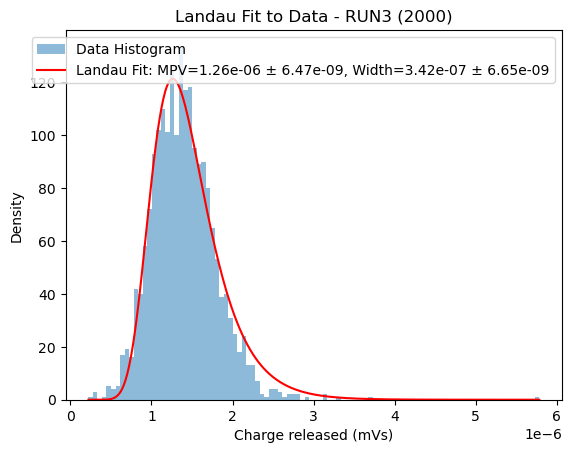

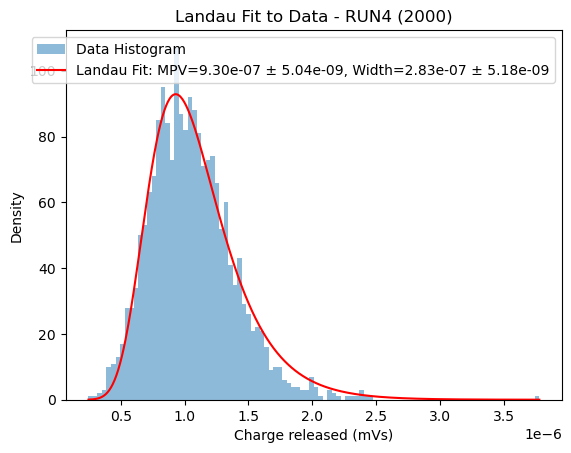

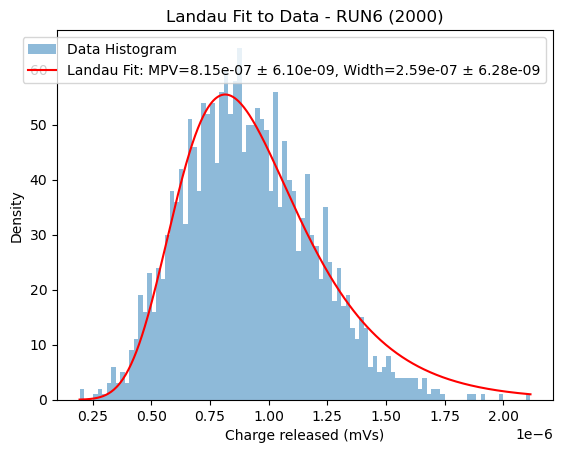

In [ ]:
areas1_small = areas1_small[areas1_small != 0]
areas2_small = areas2_small[areas2_small != 0]
areas3_small = areas3_small[areas3_small != 0]
areas4_small = areas4_small[areas4_small != 0]
areas6_small = areas6_small[areas6_small != 0]

mpv_fit1_small, eta_fit1_small, mpv_err1_small, eta_err1_small = landau_fit(areas1_small, "1 (2000)")
mpv_fit2_small, eta_fit2_small, mpv_err2_small, eta_err2_small = landau_fit(areas2_small, "2 (2000)")
mpv_fit3_small, eta_fit3_small, mpv_err3_small, eta_err3_small = landau_fit(areas3_small, "3 (2000)")
mpv_fit4_small, eta_fit4_small, mpv_err4_small, eta_err4_small = landau_fit(areas4_small, "4 (2000)")
mpv_fit6_small, eta_fit6_small, mpv_err6_small, eta_err6_small = landau_fit(areas6_small, "6 (2000)")

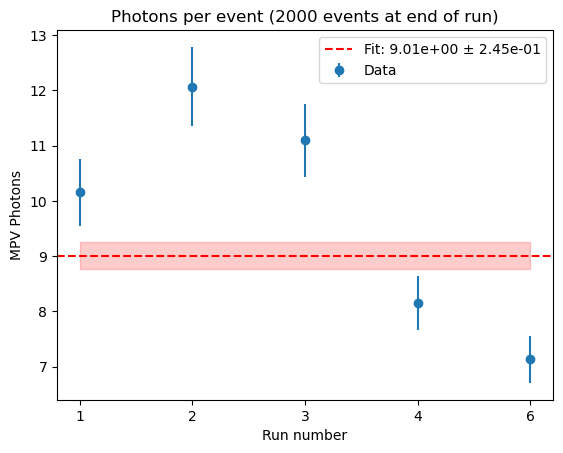

In [ ]:
means = np.array([mpv_fit1_small, mpv_fit2_small, mpv_fit3_small, mpv_fit4_small, mpv_fit6_small])
photons = (means / 1e3 - 8.42e-12) / 1.13e-10
stdevs = np.array([mpv_err1_small, mpv_err2_small, mpv_err3_small, mpv_err4_small, mpv_err6_small])
photon_err = np.sqrt((stdevs / means) ** 2 + (6.71e-12 / 1.13e-10) ** 2) * photons + 1.11e-11

x_vals = np.arange(len(means))
x_labels = [1, 2, 3, 4, 6]

# Compute the weighted mean and its error
weights = 1 / photon_err**2
constant_fit = np.sum(photons * weights) / np.sum(weights)
constant_fit_err = np.sqrt(1 / np.sum(weights))

plt.errorbar(x_vals, photons, yerr=photon_err, fmt='o', label="Data")

# Plot horizontal best-fit line
plt.axhline(y=constant_fit, color='r', linestyle='--', label=f'Fit: {constant_fit:.2e} ± {constant_fit_err:.2e}')

# Add shaded error region for the fit
plt.fill_between(x_vals, constant_fit - constant_fit_err, constant_fit + constant_fit_err, color='r', alpha=0.2)

# Customize x-axis labels
plt.xticks(x_vals, x_labels)

plt.xlabel("Run number")
plt.ylabel("MPV Photons")
plt.title("Photons per event (2000 events at end of run)")
plt.legend()

plt.show()